# Provable Robustness for Deep Classifiers

In this notebook, we will implement the robustness certificate that we derived in the PDF. That is, we will first define and train a three-layer neural classifier; then, we will calculate its dual, and using this, check whether the classifier is dual at given input points.

**Your task is to fill in any sections labeled TODO in the code and answer the bolded questions.**

## Torch

We are using torch here; for our purposes, we can think of torch as essentially numpy with GPU support and and automatic differentiation. That is, for any function we compute, torch automatically keeps track of the function's gradient with respect to inputs; this will make gradient descent much easier to implement. 

The primary object you will need to manipulate here is `torch.Tensor`, which can be thought of as equivalent to  `np.array`. Indexing, splicing, multiplication, etc. will work like you would expect them to in numpy.

Also, most of the numpy functions you are used to are present in torch, with the same name. E.g:
* `np.max(input, axis)` --> `torch.max(input, dim)` (Note that `torch.max` actually returns a tuple of the max and argmax).
* `np.zeros` --> `torch.zeros`
* `np.eye` --> `torch.eye`
* `np.linalg.norm(x, ord, axis)` --> `torch.norm(input, p, dim)`

For more information, refer to the [torch documentation](https://pytorch.org/docs/stable/torch.html) or the [torch tutorials](https://pytorch.org/tutorials/).

## Setup

Here, we import the relevant libraries.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import copy

This line tells torch to use the GPU if available, and otherwise the CPU.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Here, we load in the MNIST dataset. The inputs are $28\times 28$ images of handwritten digits, while the labels are the corresponding digit. Note that we split the data between a training set and a test set. In order to have an unbiased estimate of the classifier's performance, we must train the model only on the training set (**never the test set**), then test its accuracy on the test set.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

This is a utility function to visualize torch Tensors as images.

In [5]:
def imshow(img):
    '''
    Visualizes IMG.
    IMG should be a 2D torch Tensor.
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()

## Primal Network

Here, we define the neural classifier we will be using. Note that the network comprises three layers. The first layer has dimension $28^2$ since this is the size of the input image. (The original inputs are square images, but we flatten them into a $28^2\times 1$ vector in order to feed them into the network.) The output layer has dimension $10$, since there are ten possible output classes (the digits 0-9). The hidden layer has dimension $256$. (There isn't as much science behind choosing the dimensionality of input layers; we choose $256$ because it is a round number, and is hopefully enough to the neccesary encode information about the input image.)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(in_features=28*28, out_features = 256)
        self.fc2 = nn.Linear(in_features=256, out_features = 10)
        self.layers = [self.fc1, self.fc2]

        # define forward function
    def forward(self, t):
        '''
        On input T, performs a affine transformation, then
        a ReLU, then another affine transformation.
        '''
        self.z = []
        t = t.reshape(-1, 28*28)
        t = self.fc1(t)
        self.z.append(t)
        t = F.relu(t)
        t = self.fc2(t)
        self.z.append(t)
        return t

Here is the training code, which uses Adam, a variant of gradient descent. The actual optimization machinery is all abstracted away behind the torch library; all the work is being done by the `optimizer.step()` call.

In [7]:
def train(net, criterion, trainloader, lr=0.001):
    '''
    Uses the Adam optimization algorithm to train 
    the classifier NET on training data from TRAINLOADER,
    on loss function CRITERION, with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

We can now train the net on the training data, using cross entropy loss.

In [156]:
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()

train(net, criterion, trainloader, 0.001)

Epoch 0 Iter: 0 Loss 2.553879737854004
Epoch 0 Iter: 500 Loss 1.0748794078826904
Epoch 0 Iter: 1000 Loss 0.3809308409690857
Epoch 0 Iter: 1500 Loss 0.3111457824707031
Epoch 0 Iter: 2000 Loss 0.23070676624774933
Epoch 0 Iter: 2500 Loss 0.7990380525588989
Epoch 0 Iter: 3000 Loss 0.02094804309308529
Epoch 0 Iter: 3500 Loss 1.2673789262771606
Epoch 0 Iter: 4000 Loss 0.7534011602401733
Epoch 0 Iter: 4500 Loss 0.04742811247706413
Epoch 0 Iter: 5000 Loss 0.23849895596504211
Epoch 0 Iter: 5500 Loss 0.2747969627380371
Epoch 0 Iter: 6000 Loss 0.21337397396564484
Epoch 0 Iter: 6500 Loss 0.04961594566702843
Epoch 0 Iter: 7000 Loss 0.01025475561618805
Epoch 0 Iter: 7500 Loss 0.02217344380915165
Epoch 0 Iter: 8000 Loss 0.1617601215839386
Epoch 0 Iter: 8500 Loss 0.10260596871376038
Epoch 0 Iter: 9000 Loss 0.13065966963768005
Epoch 0 Iter: 9500 Loss 0.02441193349659443
Epoch 0 Iter: 10000 Loss 0.5819503664970398
Epoch 0 Iter: 10500 Loss 0.035115715116262436
Epoch 0 Iter: 11000 Loss 0.05623221397399902

Let's load a sample image from the test dataset, and see what the classifier makes of it. Make sure to visualize the image using `imshow(x[0,0])`. Also, note that the line `test_iter.next()` pulls a new input image from the test set each time you run it; try running the next code block a few times to get a sense of what the MNIST dataset looks like, and how the classifier performs on it.

In [157]:
test_iter = iter(testloader)

tensor([7, 2, 1, 0])
tensor([7])


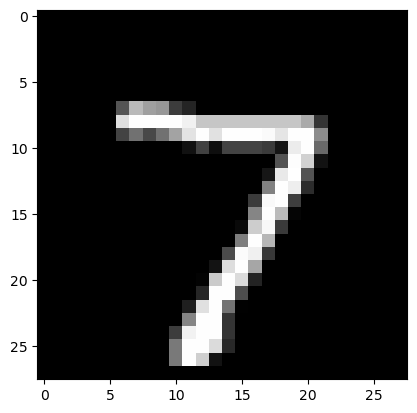

Classifier output: tensor([[ -6.9942,  -9.3703,  -0.3600,  -5.1485, -15.6292,  -8.7813, -16.5405,
           4.8512,  -7.7206,  -3.5678]])
Classifier prediction: 7


In [158]:
x, labels = next(test_iter)
print(labels)
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
print(labels)
imshow(x[0,0])

x = x.to(device)
labels = labels.to(device)
out = net(x).data
print('Classifier output:', out)
print('Classifier prediction:', torch.argmax(out).item())

We can also measure the classifier's accuracy on the full test dataset. This function takes in a classifier we have trained and the loader for the test set, and outputs the classifier's accuracy. The accuracy is simply
$$ \dfrac{\text{# correct}}{\text{# total}}.$$

In [159]:
def accuracy(net, testloader):
    '''
    Returns the accuracy of classifier NET
    on test data from TESTLOADER.
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [160]:
print('Classifier accuracy on original test dataset:', accuracy(net, testloader))

Classifier accuracy on original test dataset: 0.9717


## Fast Gradient Sign Method

Here, we implement the Fast Gradient Sign Method, which takes in a batch of input images, their labels, a trained classifier, and the epsilon radius within which the perturbation should lie. This function should output the input image perturbed in the direction of the sign of the gradient with respect to the classifier's loss.

(Note that the output is not guaranteed to lie in the valid range for images, since here pixel values must be in $[-1,1]$. You should use `torch.clamp` to fix the FGSM output to lie in the correct range.)

In [247]:
def FGSM(x, labels, net, eps):
    '''
    Given an input image X and its corresponding labels
    LABELS, as well as a classifier NET, returns X
    perturbed by EPS using the fast gradient sign method.
    '''
    net.zero_grad()    # Zero out any gradients from before
    x.requires_grad=True    # Keep track of gradients
    out = net(x)    # Output of classifier
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, labels)   # Classifier's loss
    loss.backward()
    grads = x.grad.data    # Gradient of loss w/r/t input
    x_FGSM = x + eps * grads.sign()
    x_FGSM = torch.clamp(x_FGSM, min=-1, max=1)
    return x_FGSM # TODO: Your code here!

Let's see how well the classifier does when the input is adversarially perturbed using FGSM. Try this for $\varepsilon\in\{0.05, 0.1,0.2,0.3, 0.4\}$, and again remember to visualize the inputs with `imshow`.

In [248]:
eps = 0.2 # TODO: Try eps = 0.05, 0.1, 0.2, 0.3, 0.4

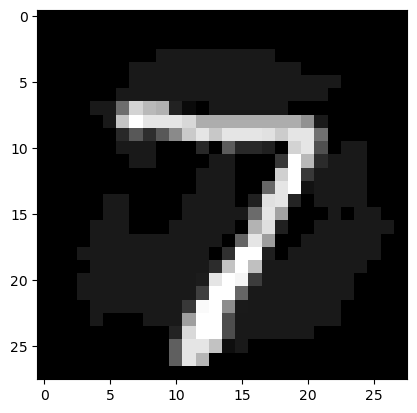

Classifier output: tensor([[ -3.1343,  -6.9668,   2.9962,  -2.5912, -15.1480,  -4.8138, -10.8714,
           0.8824,  -2.7487,  -4.1346]])
Classifier prediction: 2


In [249]:
# We are using the same sample input x as before.
x.requires_grad = True
x_prime = FGSM(x, labels, net, eps)
imshow(x_prime[0,0].cpu())
out = net(x_prime)

print('Classifier output:', out.data)
print('Classifier prediction:', torch.argmax(out).item())

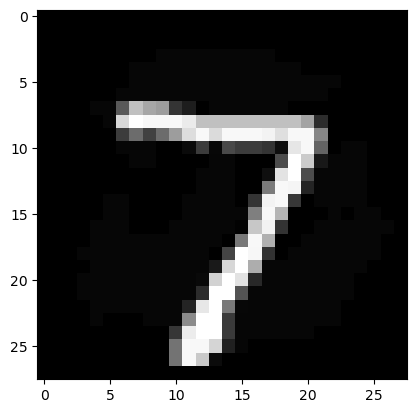

eps:  0.05
Classifier output: tensor([[ -5.7840,  -8.3389,   0.8124,  -4.3372, -15.5420,  -7.9152, -14.5623,
           3.6267,  -6.2811,  -3.7855]])
Classifier prediction: 7


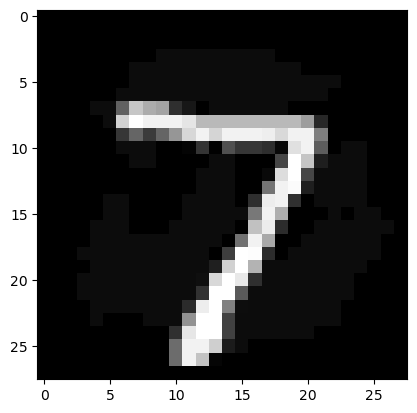

eps:  0.1
Classifier output: tensor([[ -4.7901,  -7.6804,   1.6810,  -3.6342, -15.4305,  -6.9201, -13.0734,
           2.6001,  -4.9377,  -3.9564]])
Classifier prediction: 7


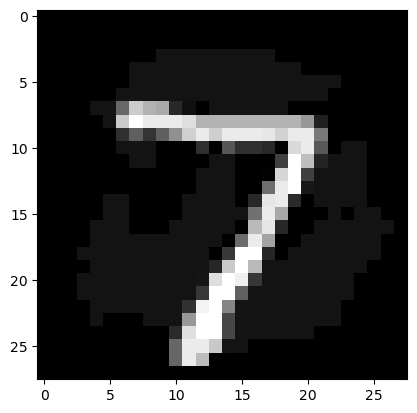

eps:  0.15
Classifier output: tensor([[ -3.8925,  -7.2379,   2.3917,  -2.9606, -15.3243,  -5.7902, -11.7609,
           1.6343,  -3.6195,  -4.0970]])
Classifier prediction: 2


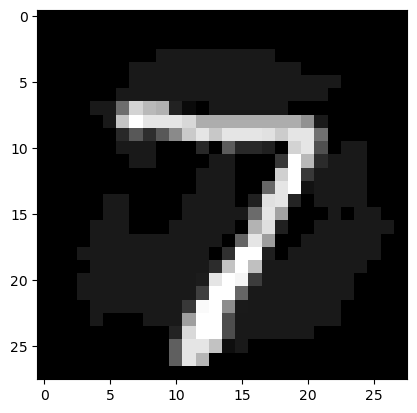

eps:  0.2
Classifier output: tensor([[ -3.1343,  -6.9668,   2.9962,  -2.5912, -15.1480,  -4.8138, -10.8714,
           0.8824,  -2.7487,  -4.1346]])
Classifier prediction: 2


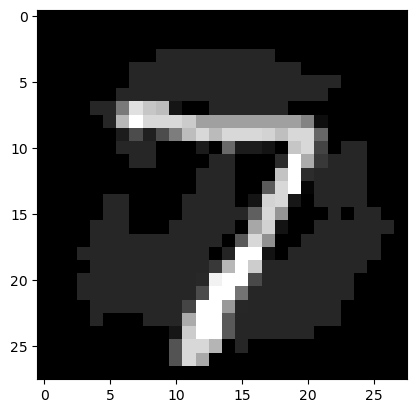

eps:  0.3
Classifier output: tensor([[ -2.0810,  -6.4237,   3.9111,  -2.0695, -14.5468,  -3.2087,  -9.2598,
          -0.4351,  -1.3412,  -4.5031]])
Classifier prediction: 2


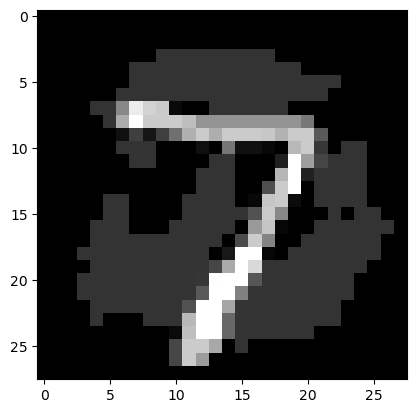

eps:  0.4
Classifier output: tensor([[ -2.2205,  -6.2833,   4.4010,  -1.2415, -14.1236,  -2.3001,  -8.1979,
          -1.6918,  -0.4858,  -5.0072]])
Classifier prediction: 2


In [250]:
for eps in [0.05, 0.1, 0.15, 0.2, 0.3, 0.4]:
    # We are using the same sample input x as before.
    x.requires_grad = True
    x_prime = FGSM(x, labels, net, eps)
    imshow(x_prime[0,0].cpu())
    out = net(x_prime)
    print('eps: ',eps)
    print('Classifier output:', out.data)
    print('Classifier prediction:', torch.argmax(out).item())

    

We should evaluate the classifier's performance on FGSM-perturbed data by the same metric that we will later use in the primal adversarial problem. That is, for the classifier's output vector $\vec{\hat{z}}_3$, we want to compute
$$
\vec{c}_j^\top \vec{\hat{z}}_3
$$
where
$$\vec{c}_j={\vec{y}_{\text{true}}}-\vec{e}_{j}$$
for each $j\in[10]$.

Recall that 
$$\vec{c}_j^\top \vec{\hat{z}}_3=\vec{\hat{z}}_{3i_{\text{true}}}-\vec{\hat{z}}_{3j},$$
i.e. $\vec{c}_j^\top \vec{\hat{z}}_3$ is the difference between the classifier's confidence on the true class and the $j$th (incorrect) class. If $\vec{c}_j^\top \vec{\hat{z}}_3$ is positive for all incorrect $j$, then the classifier was not fooled by the adversarial perturbation.

In [251]:
eps = 0.2 # TODO: Try eps = 0.05, 0.1, 0.2, 0.3, 0.4

In [252]:
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, (out @ c).item())

0 0.5286637544631958
1 4.591460227966309
2 -6.0928192138671875
3 -0.45032739639282227
4 12.431708335876465
5 0.6082996129989624
6 6.506094932556152
8 -1.206049919128418
9 3.31535005569458


**Q: What do the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores tell you about the robustness of the classifier to different values of epsilon? For a given input digit, which output categories have higher/lower scores? Why?**

A: The $\vec{c}_j^\top \vec{\hat{z}}_3$ scores tell us that the larger epsilon, the less robust of the classifier.
For a given input digit, the categories that look less similar to the input digit have higher scores, and those look more similar to the    input digit have lower scores. Because the less similarity the two digits share, the classifier is less likely to be fooled by the adversarial perturbation and thus more confident on the true class. On the other hand, the more similarity the two digits share, the classifier is more likely to be fooled by the adversarial perturbation.

Now that FGSM is defined, we can also measure a classifier's accuracy on a dataset where each input has been adversarially perturbed. That is, for each point in the original test dataset, we first perturb it using FGSM before feeding it to the classifier.

In [253]:
def accuracy_on_FGSM(net, testloader, eps):
    '''
    Returns the accuracy of classifier NET on test
    data from TESTLOADER that has been perturbed by
    EPS using FSGM.
    '''
    correct = 0
    total = 0
    for data in testloader:
        x, labels = data[0].to(device), data[1].to(device)
        x_prime = FGSM(x, labels, net, eps)
        outputs = net(x_prime)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [255]:
print('Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(net, testloader, eps))

Classifier accuracy on test dataset perturbed with FGSM: 0.5158


In [256]:
for eps in [0.05, 0.1, 0.2, 0.3, 0.4]:
    print('eps: ',eps)
    print('Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(net, testloader, eps))

eps:  0.05
Classifier accuracy on test dataset perturbed with FGSM: 0.9281
eps:  0.1
Classifier accuracy on test dataset perturbed with FGSM: 0.8421
eps:  0.2
Classifier accuracy on test dataset perturbed with FGSM: 0.5158
eps:  0.3
Classifier accuracy on test dataset perturbed with FGSM: 0.2363
eps:  0.4
Classifier accuracy on test dataset perturbed with FGSM: 0.1005


**Q: How does the classifier accuracy on data perturbed by FGSM compare to that on the original test dataset? How does this vary with epsilon?**

A: As shown above, the classifier accuracy on data perturbed by FGSM is obviously lower that on the original test dataset. As epsilon grows larger, the accuracy decreases and becomes close to zero.

## Dual Network

Here, we will implement the dual network. First, we write the function to compute upper and lower bounds for the dual network. This function should take an input image, the trained classifier, and an epsilon value, and return the tuple
$$(\vec{l},\vec{u},S,S^-,S^+)$$
where $\vec{u}$ and $\vec{l}$ are the upper and lower bounds, respectively, for the input to the ReLU layer, and $S^-,S^+,S$ are sets defined by

$$
\begin{aligned}
&S:=\{j\in [n_2]\mid l_{j}\leq 0\leq u_{j}\}\\
&S^{-}:=\{j\in [n_2]\mid l_{j}\leq u_{j}\leq 0\}\\
&S^{+}:=\{j\in [n_2]\mid 0\leq l_{j}\leq u_{j}\}.
\end{aligned}
$$

See Section 6 of the PDF for more details.

In [257]:
def dual_bounds(x, net, eps):
    '''
    Given a classifier NET, an input image X,
    and the epsilon parameter EPS, returns the lower
    and upper bounds L and U respectively, as well as
    the corresponding sets S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)  # Reshape input to more convenient dimensions
    # Array of network weights (W matrices)
    W = [layer.weight for layer in net.layers]
    # Array of network biases (b vectors)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]
    n = W[1].shape[1]  # Dimensionality of hidden layer
    norm_W = W[0].abs().sum(dim=1, keepdim=True)
    u = torch.matmul(W[0], x) + b[0] + eps * norm_W  # TODO
    l = torch.matmul(W[0], x) + b[0] - eps * norm_W  # TODO
    S = torch.where((l <= 0) & (u >= 0))[0]  # TODO
    S_plus = torch.where(l >= 0)[0]  # TODO
    S_min = torch.where(u <= 0)[0]  # TODO
    return l, u, S, S_min, S_plus

Given the tuple $(l,u,S,S^-,S^+)$, we are ready to calculate the dual objective itself. This function should take in an input image, the classifier, a vector $c$, and the $(l,u,S,S^-,S^+)$ from the previous function in order to output 
$$
d^*(\vec{x},\vec{c})= 
-\vec{\hat{\nu}}_1^\top \vec{x}-\varepsilon\|\vec{\hat{\nu}}_1\|_1-\sum_{i=1}^{2}\vec{\nu}_{i+1}^\top \vec{b}_i+\sum_{j\in S\
}l_{j}\text{ReLU}(\nu_{2j})
$$

Where the $\vec{\nu}$ vectors are computed as
$$
\begin{aligned}
&\vec{\nu}_3=-\vec{c}\\
&\vec{\hat{\nu}}_2=W_2^\top \vec{\nu}_{3}\\
&\nu_{2j}=0 && \forall j\in S^-\\
&\nu_{2j}=\hat{\nu}_{2j} && \forall j\in S^+\\
&\nu_{2j}=\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{2j} && \forall j\in S\\
&\vec{\hat{\nu}}_1=W_1^\top \vec{\nu_{2}}
&\end{aligned}.
$$

Again, see Section 6 of the PDF for more details.

One efficient way to compute $\vec{\nu}_2$ is to rewrite it as
$$\vec{\nu}_2= D\vec{\hat{\nu}}_2,$$
where $D$ is a diagonal matrix defined  by
$$
D_{jj}=\begin{cases}
0 & j\in S^-\\
\hat{\nu}_{2j} & j\in S^+\\
\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{2j} & j\in S.
\end{cases}
$$

In [258]:
# Constructs the diagonal D matrix from the S sets, n (the dimensionality
# of the hidden layer), u, and l.
def StoD(S_min, S_plus, S, n, u, l):
    '''
    Given upper and lower bounds U and L, as well
    as the corresponding sets S_MIN, S_PLUS, and S,
    as well as the dimension of the hidden layer N,
    returns the corresponding diagonal matrix D.
    '''
    d = []
    for j in range(n):
        if j in S:
            d.append((u[j] / (u[j] - l[j])).item())
        elif j in S_plus:
            d.append(1)
        elif j in S_min:
            d.append(0)
        else:
            assert False, 'StoD error.'
    return torch.diag(torch.Tensor(d)).to(device)


def dual_forward(x, net, c, eps, l, u, S, S_min, S_plus):
    '''
    Calculates the dual objective for classifier NET with input X
    and dual input C and epsilon parameter S. Depends on lower
    and upper bounds L and U, as well as the corresponding sets
    S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)  # Reshape input to more convenient dimensions
    W = [layer.weight
         for layer in net.layers]  # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1)
         for layer in net.layers]  # Array of network biases (b vectors)
    n = W[1].shape[1]  # Dimensionality of hidden layer
    D = StoD(S_min, S_plus, S, n, u, l)
    # TODO: Your code here!
    nu_3 = -c
    hat_nu_2 = torch.matmul(W[1].t(), nu_3)
    nu_2 = torch.matmul(D, hat_nu_2)
    hat_nu_1 = torch.matmul(W[0].t(), nu_2)
    sum_relu = torch.zeros(c.shape[1], 1, device=c.device)
    for i, j in enumerate(S):
        sum_relu += l[j] * F.relu(nu_2[j, :]).unsqueeze(0).t()
    hat_nu_1_t = hat_nu_1.t()
    norm_hat_nu_1 = hat_nu_1_t.abs().sum(dim=1, keepdim=True)
    dual_obj = -torch.matmul(
        hat_nu_1.t(), x) - eps * norm_hat_nu_1 - torch.matmul(
            nu_2.t(), b[0]) - torch.matmul(nu_3.t(), b[1]) + sum_relu
    return dual_obj  # TODO

Now, we can use the dual network to check the robustness of the network we just trained on sample input images. We can do this for 
$$\vec{c}_j={\vec{y}_{\text{true}}}-\vec{e}_{j}$$
for each $j\in[10]$.

The output is a vector where the $j$th element is the difference between the model's confidence in the true class and the $j$th class; if $d^*(\vec{x},\vec{c}_j)$ is nonnegative for every $j\in[10]$, then we know the model is robust to perturbations of size $\varepsilon$. See Section 8 of the PDF for more details.

Try running the following block of code for different values of $\varepsilon\in\{0.05, 0.1, 0.2, 0.3, 0.4\}$, and compare the robustness guarantees here with the classifier's performance on the FGSM data from before.

In [259]:
eps = 0.05 # TODO: Try eps = 0.05, 0.1, 0.2, 0.3, 0.4

In [260]:
# We are still using the same sample input x as before.
l, u, S, S_min, S_plus = dual_bounds(x, net, eps)

# Here, we loop through each column c_j defined above, and output the 
# objective value for the dual function with input c.
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, dual_forward(x, net, c, 0.1, l, u, S, S_min, S_plus).item())

0 -0.2960551381111145
1 2.6558425426483154
2 -4.843652725219727
3 0.03950619697570801
4 6.922565937042236
5 1.4014372825622559
6 7.601950168609619
8 -0.7971267700195312
9 -1.270868182182312


In [261]:
for eps in [0.05, 0.1, 0.2, 0.3, 0.4]:
    print('\neps: ',eps)
    x.requires_grad = True
    x_prime = FGSM(x, labels, net, eps)
    out = net(x_prime)
    for i in range(10):
        c = torch.zeros(10, 1).to(device)
        if i != labels:
            c[i] = -1
            c[labels] = 1
            print(i, 'FGSM:',round((out @ c).item(),2), '; Dual:', round(dual_forward(x, net, c, eps, l, u, S, S_min, S_plus).item(),2))
    


eps:  0.05
0 FGSM: 9.41 ; Dual: 5.39
1 FGSM: 11.97 ; Dual: 7.61
2 FGSM: 2.81 ; Dual: -0.32
3 FGSM: 7.96 ; Dual: 4.48
4 FGSM: 19.17 ; Dual: 12.98
5 FGSM: 11.54 ; Dual: 6.75
6 FGSM: 18.19 ; Dual: 13.94
8 FGSM: 9.91 ; Dual: 5.1
9 FGSM: 7.41 ; Dual: 2.81

eps:  0.1
0 FGSM: 7.39 ; Dual: -0.3
1 FGSM: 10.28 ; Dual: 2.66
2 FGSM: 0.92 ; Dual: -4.84
3 FGSM: 6.23 ; Dual: 0.04
4 FGSM: 18.03 ; Dual: 6.92
5 FGSM: 9.52 ; Dual: 1.4
6 FGSM: 15.67 ; Dual: 7.6
8 FGSM: 7.54 ; Dual: -0.8
9 FGSM: 6.56 ; Dual: -1.27

eps:  0.2
0 FGSM: 4.02 ; Dual: -11.66
1 FGSM: 7.85 ; Dual: -7.25
2 FGSM: -2.11 ; Dual: -13.89
3 FGSM: 3.47 ; Dual: -8.85
4 FGSM: 16.03 ; Dual: -5.2
5 FGSM: 5.7 ; Dual: -9.3
6 FGSM: 11.75 ; Dual: -5.08
8 FGSM: 3.63 ; Dual: -12.6
9 FGSM: 5.02 ; Dual: -9.44

eps:  0.3
0 FGSM: 1.65 ; Dual: -23.03
1 FGSM: 5.99 ; Dual: -17.15
2 FGSM: -4.35 ; Dual: -22.94
3 FGSM: 1.63 ; Dual: -17.73
4 FGSM: 14.11 ; Dual: -17.31
5 FGSM: 2.77 ; Dual: -20.01
6 FGSM: 8.82 ; Dual: -17.75
8 FGSM: 0.91 ; Dual: -24.4
9 FGSM: 

**Q: What do the dual network outputs tell you about the robustness of the classifier? How does this compare to the classifier's performance (in particular, the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores) on FGSM outputs? How does your answer change with epsilon?**

A: The dual network outputs tell us about the lower bound of the robustness of the classifier. From above, we can clearly see that the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores of the dual network's outputs are lower than those on FGSM outputs for every $j$, so the dual network is able to provide robustness guarantee. As epsilon grows larger, the scores become lower, which means the classifier is less confident. 

**Q: Suppose you have a deep neural classifier that you want to defend against adversarial attacks. That is, you want to detect and discard any input images that were possibly adversarially perturbed. How might you do this with the robustness certificate you have implemented?**

A: Using the dual network , we are able to check the robustness of the primal network on any input.  if all of the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores are positive, then the classifier is robust on the input,so there can be no possible perturbation that would fool the classifier. Otherwise, if any of the $\vec{c}_j^\top \vec{\hat{z}}_3$ scores is negative, then we can discard this input, as it is possibly adversarially perturbed.

## Robust training

The following function should implement the robust loss from the PDF. This loss is an upper bound on the worst-case loss within an $\epsilon$ ball of the original training input. Thus, training using this new loss should result in a classifier that is more robust than one trained on the original cross-entropy loss.

There are no mandatory questions here, but feel free to experiment with this robust training, and compare the performance here (measured by the dual objective certificate, as well as original/FGSM accuracy) to that of the original. You can also try training a model using the original loss first, then fine-tuning with the robust loss.

In [262]:
def robust_loss(x, label, net, eps, criterion):
    '''
    Given a batch of input images X, its corresponding lables LABEL,
    the classifier NET, epsilon value EPS, and original loss
    function CRITERION, returns the robust loss of NET w/r/t
    the original loss function, on the input image.
    '''
    
    l, u, S, S_min, S_plus = dual_bounds(x, net, eps)
    # We assume there are 10 classes.
    e_y = torch.zeros(10, 1)
    e_y[label] = 1
    c = e_y @ torch.ones(1, 10) - torch.eye(10)
    J = dual_forward(x, net, c, eps, l, u, S, S_min, S_plus).unsqueeze(0)

    return criterion(-J, label.unsqueeze(0))

In [263]:
def robust_train(net, criterion, trainloader, eps, lr=0.001):
    '''
    Trains the classifier NET using the robust version
    of the original loss function CRITERION with paramater EPS,
    using training data from TRAINLOADER and with learning rate LR.
    def robust_loss(x, label, net, eps, criterion):
    
    Given a batch of input images X, its corresponding lables LABEL,
    the classifier NET, epsilon value EPS, and original loss
    function CRITERION, returns the robust loss of NET w/r/t
    the original loss function, on the input image.
    
    l, u, S, S_min, S_plus = dual_bounds(x, net, eps)
    # We assume there are 10 classes.
    e_y = torch.zeros(10, 1)
    e_y[label] = 1
    c = e_y @ torch.ones(1, 10) - torch.eye(10)
    J = dual_forward(x, net, c, eps, l, u, S, S_min, S_plus).unsqueeze(0)
    return criterion(-J, label.unsqueeze(0))
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data
            optimizer.zero_grad()
            loss = 0
            for i in range(inputs.shape[0]):
                x = inputs[i].unsqueeze(0)
                label = labels[i].unsqueeze(0)
                loss += robust_loss(x, label, net, eps, criterion)
            loss.backward()
            optimizer.step()

            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

### We implement the robust training with epsilon = 0.05, 0.1, 0.2, 0.3. From the results below, we can clearly see that the robust training significantly improves the accuracy on test dataset perturbed with corresponding epsilon by FGSM , compared to the performance of the original classifier.


### Original Classifier

In [264]:
print('Classifier accuracy on original test dataset:', accuracy(net, testloader))

Classifier accuracy on original test dataset: 0.9717


In [265]:
for eps in [0.05, 0.1, 0.2, 0.3, 0.4]:
    print('eps: ',eps)
    print('Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(net, testloader, eps))

eps:  0.05
Classifier accuracy on test dataset perturbed with FGSM: 0.9281
eps:  0.1
Classifier accuracy on test dataset perturbed with FGSM: 0.8421
eps:  0.2
Classifier accuracy on test dataset perturbed with FGSM: 0.5158
eps:  0.3
Classifier accuracy on test dataset perturbed with FGSM: 0.2363
eps:  0.4
Classifier accuracy on test dataset perturbed with FGSM: 0.1005


### Robust classifier with epsilon = 0.05

In [ ]:
robust_net0 = Net()
robust_net0.to(device)
criterion = nn.CrossEntropyLoss()
robust_train(robust_net0, criterion, trainloader, eps=0.05, lr=0.001)

In [266]:
print('Classifier accuracy on robust test dataset:', accuracy(robust_net0, testloader))

Classifier accuracy on robust test dataset: 0.953


In [198]:
for eps in [0.05, 0.1, 0.2, 0.3, 0.4]:
    print('eps: ',eps)
    print('Robust Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(robust_net, testloader, eps))

eps:  0.05
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.9064
eps:  0.1
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.8321
eps:  0.2
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.5914
eps:  0.3
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.2918
eps:  0.4
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.0838


### Robust classifier with epsilon = 0.1

In [246]:
robust_net1 = Net()
robust_net1.to(device)
criterion = nn.CrossEntropyLoss()
robust_train(robust_net1, criterion, trainloader, eps=0.1, lr=0.001)

In [267]:
print('Classifier accuracy on robust test dataset:', accuracy(robust_net1, testloader))

Classifier accuracy on robust test dataset: 0.9135


In [268]:
for eps in [0.05, 0.1, 0.2, 0.3, 0.4]:
    print('eps: ',eps)
    print('Robust Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(robust_net1, testloader, eps))

eps:  0.05
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.8833
eps:  0.1
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.846
eps:  0.2
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.7373
eps:  0.3
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.5881
eps:  0.4
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.388


### Robust classifier with epsilon = 0.2

In [184]:
robust_net2 = Net()
robust_net2.to(device)
criterion = nn.CrossEntropyLoss()
robust_train(robust_net2, criterion, trainloader, eps=0.2, lr=0.001)

In [185]:
print('Classifier accuracy on robust test dataset:', accuracy(robust_net2, testloader))

Classifier accuracy on robust test dataset: 0.8179


In [186]:
for eps in [0.05, 0.1, 0.2, 0.3, 0.4]:
    print('eps: ',eps)
    print('Robust Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(robust_net2, testloader, eps))

eps:  0.05
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.7653
eps:  0.1
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.7109
eps:  0.2
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.5756
eps:  0.3
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.42
eps:  0.4
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.2605


### Robust classifier with epsilon = 0.3

In [209]:
robust_net3 = Net()
robust_net3.to(device)
criterion = nn.CrossEntropyLoss()
robust_train(robust_net3, criterion, trainloader, eps=0.3, lr=0.001)

In [210]:
print('Classifier accuracy on robust test dataset:', accuracy(robust_net3, testloader))

Classifier accuracy on robust test dataset: 0.7708


In [211]:
for eps in [0.05, 0.1, 0.2, 0.3, 0.4]:
    print('eps: ',eps)
    print('Robust Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(robust_net3, testloader, eps))

eps:  0.05
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.7227
eps:  0.1
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.6641
eps:  0.2
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.5441
eps:  0.3
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.4055
eps:  0.4
Robust Classifier accuracy on test dataset perturbed with FGSM: 0.2642


In [242]:
torch.save(robust_net0.state_dict(),"eps0.05_params.pth")

In [244]:
torch.save(robust_net2.state_dict(),"eps0.2_params.pth")